In [1]:
import time, pickle, os

import torch
from torchvision import datasets
import pytorch_lightning as pl

import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KDTree

import pandas as pd

import models, utils

In [2]:
pd.set_option('display.max_rows', 200)

### Display  Parameters

In [13]:
with open("hyperparameters.pkl", "rb") as file:
    df = pd.read_pickle(file)
    print(df)

   dimensions       dataset    model      type                       time
0         800  fashionmnist  basicnn     basic 2023-04-17 19:31:44.568571
1         400  fashionmnist  basicnn     basic 2023-04-17 19:32:52.723188
2         200  fashionmnist  basicnn     basic 2023-04-17 19:34:28.997886
3         100  fashionmnist  basicnn     basic 2023-04-17 19:36:03.669816
4          50  fashionmnist  basicnn     basic 2023-04-17 19:37:33.185732
5          25  fashionmnist  basicnn     basic 2023-04-17 19:39:02.703332
6         800  fashionmnist  basicnn   autoenc 2023-04-17 19:40:54.606711
7         400  fashionmnist  basicnn   autoenc 2023-04-17 19:42:51.196482
8         200  fashionmnist  basicnn   autoenc 2023-04-17 19:44:46.260483
9         100  fashionmnist  basicnn   autoenc 2023-04-17 19:46:26.261599
10         50  fashionmnist  basicnn   autoenc 2023-04-17 19:48:05.510076
11         25  fashionmnist  basicnn   autoenc 2023-04-17 19:49:44.874378
12        128          sift  basicnn  

In [14]:
with open("indices.pkl", "rb") as file:
    df = pd.read_pickle(file)
    print(df)

     index  index_param  reduction_model                       time
0   kdtree           -1                7 2023-04-25 04:19:37.172964
1     pynn            5                7 2023-04-25 04:19:59.489945
2     pynn           10                7 2023-04-25 04:20:30.324162
3     pynn           25                7 2023-04-25 04:21:02.891798
4     pynn           50                7 2023-04-25 04:21:40.618108
5     hnsw            5                7 2023-04-25 04:22:24.425375
6     hnsw           10                7 2023-04-25 04:22:57.641592
7     hnsw           25                7 2023-04-25 04:23:31.262171
8     hnsw           50                7 2023-04-25 04:24:04.715073
9   kdtree           -1                9 2023-04-25 04:24:16.523735
10    pynn            5                9 2023-04-25 04:24:37.658273
11    pynn           10                9 2023-04-25 04:25:08.766737
12    pynn           25                9 2023-04-25 04:25:40.391001
13    pynn           50                9 2023-04

### Benchmark Models

In [3]:
def analyseResults(dataset : utils.H5Loader, queries, results : np.ndarray):
    errors = []
    failed = 0
    for q,rs in zip(queries, results):

        if results.ndim == 1:
            r = rs
        else:
            qraw = dataset.test.raw[q]
            # TODO
            r = rs[0]

        x = np.argmax(dataset.neighbours[q] == r)
        if dataset.neighbours[q][x] == r:
            errors.append(x)
        else:
            failed += 1
    errors = np.array(errors)

    return {
        "mean":np.mean(errors),
        "std":np.std(errors),
        "acc":100*np.mean(errors == 0),
        "fail":100*(failed / len(results))
    }

In [4]:
def benchmarkModel(df, idx, dataset=None, query_count=1000):
    if dataset == None:
        dataset = utils.loadH5Dataset(utils.DATASETS[df.iloc[idx]["dataset"]])

    model = utils.loadModel(df, idx)
    
    # Generate embeddings
    trainer = pl.Trainer(logger=False, **utils.TRAINER_ARGS)
    train_loader = utils.createDataLoader(dataset.train)
    train_embeddings = utils.numpyConvert(torch.cat(trainer.predict(model, train_loader)))
    test_loader = utils.createDataLoader(dataset.test)
    test_embeddings = utils.numpyConvert(torch.cat(trainer.predict(model, test_loader)))

    query_count = min(query_count, len(test_embeddings))
    query_idxs = np.arange(len(test_embeddings))
    np.random.shuffle(query_idxs)
    query_idxs = query_idxs[:query_count]

    if True: # Use KD-tree
        kdtree = KDTree(train_embeddings)
        nearest = kdtree.query(test_embeddings[query_idxs], return_distance=False)

    else: # Approximate by just testing with 100 nearest
        nearest = []
        for idx in query_idxs:
            deltas = train_embeddings[dataset.neighbours[idx]] - test_embeddings[idx]
            deltas = np.sum(np.square(deltas), 1)
            nearest.append(dataset.neighbours[np.argmin(deltas)])
        nearest = np.array(nearest)

    return analyseResults(dataset, query_idxs, nearest)
    

In [5]:
with open("hyperparameters.pkl", "rb") as file:
    df = pd.read_pickle(file)

def printResults(results):
    print("Ave.: ", results["mean"])
    print("Dev.: ", results["std"])
    print("Acc.: ", results["acc"], "%")
    print("Fail.:", results["fail"], "%")

printResults(benchmarkModel(df, 1))
printResults(benchmarkModel(df, 7))
printResults(benchmarkModel(df, 51))
printResults(benchmarkModel(df, 57))
printResults(benchmarkModel(df, 64))

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


Ave.:  5.723643807574207
Dev.:  12.16373218142432
Acc.:  37.66632548618219 %
Fail.: 2.3 %


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


Ave.:  1.085
Dev.:  4.808926595405673
Acc.:  72.5 %
Fail.: 0.0 %


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


Ave.:  56.888888888888886
Dev.:  34.148188318446685
Acc.:  0.0 %
Fail.: 99.1 %


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


Ave.:  1.5662650602409638
Dev.:  5.893007437008258
Acc.:  69.07630522088354 %
Fail.: 0.4 %


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Ave.:  6.031413612565445
Dev.:  13.4519138789592
Acc.:  40.52356020942408 %
Fail.: 4.5 %


In [6]:
logger = pl.loggers.CSVLogger("")

# path="reduce.ckpt"
# model = models.ReductionSpaceConserving.load_from_checkpoint(path, model=models.BasicConv)
# dimensions=model.dimensions
# print(f"Loaded model {path} with {dimensions}D")

trainer = pl.Trainer(logger=logger, **utils.TRAINER_ARGS)
# train_encodings = torch.cat(trainer.predict(model, train_loader))
# test_encodings = torch.cat(trainer.predict(model, test_loader))

train_npdata = utils.numpyConvert(train_data.data)
test_npdata = utils.numpyConvert(test_data.data)
# train_encodings = utils.numpyConvert(train_encodings)
# test_encodings = utils.numpyConvert(test_encodings)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


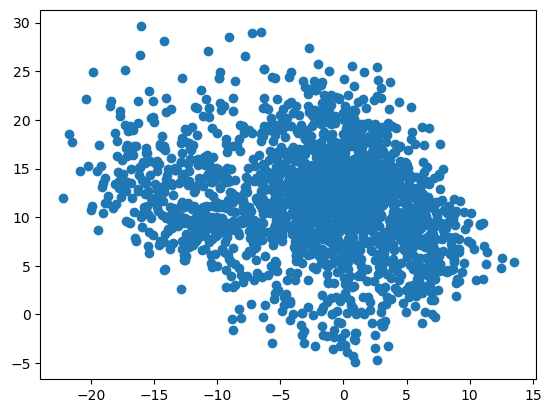

In [51]:
# Visualise a random 2D slice
num_points = 2000
idxs = np.random.randint(0, len(train_encodings), num_points)

ax0 = np.random.normal(0, 1, dimensions)
ax0 /= np.linalg.norm(ax0)

ax1 = np.random.normal(0, 1, dimensions)
ax1 = ax1 - ax0 * np.dot(ax0, ax1) # Perpendicular
ax1 /= np.linalg.norm(ax1)


points = train_encodings[idxs]
plt.scatter(np.dot(points, ax0), np.dot(points, ax1))
plt.show()

In [16]:
# Evaluate accuracy of NNs in reduced dimensional space
def evalModel(test_enc, train_enc):
    num_queries = 700
    num_points = 14000
    idxs = np.random.randint(0, len(test_npdata), num_queries)

    errors = []
    for idx in idxs:
        query = test_npdata[idx]
        query_enc = test_enc[idx]

        deltas = train_npdata[:num_points] - query
        deltas_enc = train_enc[:num_points] - query_enc

        deltas = np.sum(np.square(deltas), 1)
        deltas_enc = np.sum(np.square(deltas_enc), 1)

        nn = np.argmin(deltas)
        sort_enc = np.argsort(deltas_enc)

        error = np.argmax(sort_enc == nn)
        errors.append(error)

    return np.array(errors)

# errors = evalModel(test_encodings, train_encodings)
# print("Raw: ", errors[:20])
# print("Ave.:", np.mean(errors))
# print("Dev.:", np.std(errors))
# print("Acc.:", 100 * np.mean(errors == 0), "%")
# print("Max.:", np.max(errors))

In [13]:
uniform_data = utils.UniformDataset(2, 50_000)
args = utils.LOADER_ARGS
args["batch_size"] = 16
uniform_loader = torch.utils.data.DataLoader(uniform_data, **args)

In [16]:
# Train a space-filling curve
sfc = models.SFCModel(models.BasicNN, inputs=2, width=5000, p=2.0)
args = utils.TRAINER_ARGS
args["max_epochs"] = 2
trainer = pl.Trainer(logger=logger, **args)
trainer.fit(sfc, uniform_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | BasicNN | 25.0 M
----------------------------------
25.0 M    Trainable params
0         Non-trainable params
25.0 M    Total params
50.050    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 3125it [00:00, ?it/s]

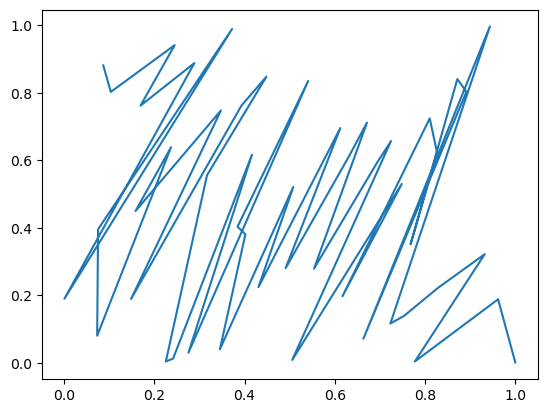

In [18]:
zero_data = utils.UniformDataset(1, 1)
d = np.copy(uniform_data.data.detach().cpu().numpy())
#d[:,2] = 0.0
zero_data.data = torch.from_numpy(d)
zero_loader = utils.createDataLoader(zero_data)

uniform_encodings = torch.cat(trainer.predict(sfc, zero_loader))
uniform_encodings = utils.numpyConvert(uniform_encodings).flatten()
uniform_npdata = utils.numpyConvert(zero_data.data)

order = np.argsort(uniform_encodings)
uniform_sorted = uniform_npdata[order]

samples = 100
xs = []
ys = []
for i in range(samples):
    idx = int(i/samples * len(uniform_data))
    xs.append(uniform_sorted[idx][0])
    ys.append(uniform_sorted[idx][1])

plt.plot(xs, ys)
plt.show()

In [17]:
xs = [800, 400, 200, 100, 50, 25]
param_df = pd.read_pickle("hyperparameters.pkl")

logger = pl.loggers.CSVLogger("")

errors = {}
for i in range(6):
    model = utils.loadModel(param_df, i)
    trainer = pl.Trainer(logger=logger, **utils.TRAINER_ARGS)
    train_encodings = torch.cat(trainer.predict(model, train_loader))
    test_encodings = torch.cat(trainer.predict(model, test_loader))
    train_encodings = utils.numpyConvert(train_encodings)
    test_encodings = utils.numpyConvert(test_encodings)
    errors[i] = evalModel(test_encodings, train_encodings)
    print(f"Done {i}!")

for i in range(6):
    i += 6
    model = models.ReductionSpaceConserving.load_from_checkpoint(f"checkpoints\\{i}.ckpt", model=models.BasicConv)
    trainer = pl.Trainer(logger=logger, **utils.TRAINER_ARGS)
    train_encodings = torch.cat(trainer.predict(model, train_loader))
    test_encodings = torch.cat(trainer.predict(model, test_loader))
    train_encodings = utils.numpyConvert(train_encodings)
    test_encodings = utils.numpyConvert(test_encodings)
    errors[i] = evalModel(test_encodings, train_encodings)
    print(f"Done {i}!")

for i in range(6):
    i += 12
    model = models.ReductionWeightedSpaceConserving.load_from_checkpoint(f"checkpoints\\{i}.ckpt", model=models.BasicConv)
    trainer = pl.Trainer(logger=logger, **utils.TRAINER_ARGS)
    train_encodings = torch.cat(trainer.predict(model, train_loader))
    test_encodings = torch.cat(trainer.predict(model, test_loader))
    train_encodings = utils.numpyConvert(train_encodings)
    test_encodings = utils.numpyConvert(test_encodings)
    errors[i] = evalModel(test_encodings, train_encodings)
    print(f"Done {i}!")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 0!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 1!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 2!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 3!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 4!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 5!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 6!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 7!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 8!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 9!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 10!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 11!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 12!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 13!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 14!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 15!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Done 16!


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Done 17!


In [19]:
aves = [0]*18
stds = [0]*18
accs = [0]*18
for i in range(18):
    aves[i] = np.mean(errors[i])
    stds[i] = np.std(errors[i])
    accs[i] = 100 * np.mean(errors[i] == 0)

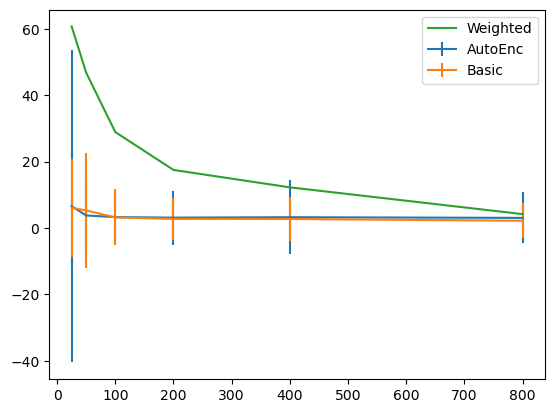

In [20]:
plt.errorbar(xs, aves[:6], yerr=stds[:6], label="AutoEnc")
plt.errorbar(xs, aves[6:12], yerr=stds[6:12], label="Basic")
plt.plot(xs, aves[12:], label="Weighted")
plt.legend()
plt.show()

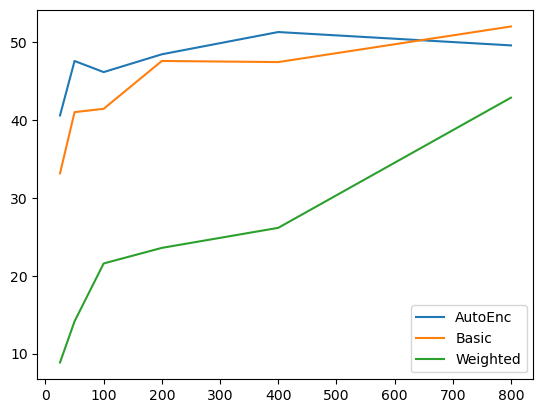

In [21]:
plt.plot(xs, accs[:6], label="AutoEnc")
plt.plot(xs, accs[6:12], label="Basic")
plt.plot(xs, accs[12:], label="Weighted")
plt.legend()
plt.show()

### Benchmark Indices

In [26]:
query_count = 800

def executeIndex(df, idx, queries, k):
    row = df.iloc[idx]
    kind = row["index"]
    with open(os.path.join("indices", f"{idx}.pkl"), "rb") as indexfile:
        index = pickle.load(indexfile)

    start = time.time()
    if kind == "kdtree":
        results = index.query(queries, k=k, return_distance=False)
    elif kind == "pynn":
        results = index.query(queries, k=k)[0]
    elif kind == "hnsw":
        results = index.knn_query(queries, k=k)[0]
    stop = time.time()

    return results, stop-start

def benchmarkIndex(df, idx, dataset=None, query_embeddings=None, query_idxs=None):
    results, delta = executeIndex(df, idx, query_embeddings)

    stats = analyseResults(dataset, query_idxs, results)
    stats["idx"] = idx
    stats["time"] = delta

    return stats

model_df = pd.read_pickle("hyperparameters.pkl")
index_df = pd.read_pickle("indices.pkl").join(model_df, on="reduction_model", rsuffix="_model")
result_df = pd.DataFrame()

for idx, row in index_df.iterrows():
    dataset = utils.loadH5Dataset(utils.DATASETS[row["dataset"]])
    
    query_idxs = np.arange(len(dataset.test))
    np.random.shuffle(query_idxs)
    query_idxs = query_idxs[:min(query_count, len(query_idxs))]

    model = utils.loadModel(model_df, row["reduction_model"])
    trainer = pl.Trainer(logger=False, **utils.TRAINER_ARGS)
    test_loader = utils.createDataLoader(dataset.test)
    test_embeddings = utils.numpyConvert(torch.cat(trainer.predict(model, test_loader)))
    query_embeddings = test_embeddings[query_idxs]

    stats = benchmarkIndex(index_df, idx, dataset=dataset, query_embeddings=query_embeddings, query_idxs=query_idxs)
    print(stats)
    row = pd.DataFrame(stats, index=[0])
    result_df = pd.concat([result_df, row], ignore_index=True)

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.04875, 'std': 4.461655907563917, 'acc': 71.875, 'fail': 0.0, 'idx': 0, 'time': 14.865583181381226}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


{'mean': 8.307387862796833, 'std': 16.44385099838083, 'acc': 32.58575197889182, 'fail': 5.25, 'idx': 1, 'time': 0.007520198822021484}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


{'mean': 4.1038461538461535, 'std': 10.204736737112196, 'acc': 48.333333333333336, 'fail': 2.5, 'idx': 2, 'time': 0.006506919860839844}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 2.332070707070707, 'std': 7.815555697689536, 'acc': 55.17676767676768, 'fail': 1.0, 'idx': 3, 'time': 0.00751042366027832}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 2.0252206809583857, 'std': 8.00437266898134, 'acc': 61.79066834804539, 'fail': 0.8750000000000001, 'idx': 4, 'time': 0.01051950454711914}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 0.9773869346733668, 'std': 2.875033966332918, 'acc': 66.95979899497488, 'fail': 0.5, 'idx': 5, 'time': 0.04809212684631348}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.0237797246558198, 'std': 3.858340799319578, 'acc': 70.08760951188987, 'fail': 0.125, 'idx': 6, 'time': 0.04661130905151367}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 0.9962358845671268, 'std': 3.6587477387593514, 'acc': 70.38895859473023, 'fail': 0.375, 'idx': 7, 'time': 0.046582698822021484}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


{'mean': 1.0902255639097744, 'std': 4.348465543234748, 'acc': 68.67167919799499, 'fail': 0.25, 'idx': 8, 'time': 0.04660463333129883}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


{'mean': 1.7277289836888332, 'std': 5.912146142210228, 'acc': 62.86072772898369, 'fail': 0.375, 'idx': 9, 'time': 4.322429895401001}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'mean': 7.472074468085107, 'std': 14.707042275899418, 'acc': 33.244680851063826, 'fail': 6.0, 'idx': 10, 'time': 0.003004789352416992}


c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 4.9055627425614485, 'std': 12.415828173626103, 'acc': 46.57179818887451, 'fail': 3.375, 'idx': 11, 'time': 0.0035185813903808594}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 2.8430379746835444, 'std': 7.7554828876958215, 'acc': 53.79746835443038, 'fail': 1.25, 'idx': 12, 'time': 0.0040018558502197266}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 2.0641509433962266, 'std': 5.899123514672925, 'acc': 57.23270440251572, 'fail': 0.625, 'idx': 13, 'time': 0.004523754119873047}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.9520807061790668, 'std': 6.37125669015914, 'acc': 63.43001261034048, 'fail': 0.8750000000000001, 'idx': 14, 'time': 0.0075397491455078125}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.5823899371069183, 'std': 5.097212638112887, 'acc': 63.14465408805031, 'fail': 0.625, 'idx': 15, 'time': 0.009523153305053711}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.8083756345177664, 'std': 6.271973021688393, 'acc': 64.9746192893401, 'fail': 1.5, 'idx': 16, 'time': 0.01353144645690918}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 1.4591194968553458, 'std': 5.319883360858759, 'acc': 64.27672955974842, 'fail': 0.625, 'idx': 17, 'time': 0.008521556854248047}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 3.8072445019404917, 'std': 9.723225381124637, 'acc': 49.159120310478656, 'fail': 3.375, 'idx': 18, 'time': 0.36591100692749023}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'mean': 10.874822190611665, 'std': 18.1869141658089, 'acc': 29.72972972972973, 'fail': 12.125, 'idx': 19, 'time': 0.0020062923431396484}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 7.993351063829787, 'std': 16.02785834182753, 'acc': 35.1063829787234, 'fail': 6.0, 'idx': 20, 'time': 0.0020020008087158203}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'mean': 6.7175066312997345, 'std': 14.30210372537696, 'acc': 38.9920424403183, 'fail': 5.75, 'idx': 21, 'time': 0.0024902820587158203}


c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 5.37109375, 'std': 12.753841245367777, 'acc': 44.66145833333333, 'fail': 4.0, 'idx': 22, 'time': 0.0029976367950439453}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


{'mean': 4.723294723294723, 'std': 11.465325059503895, 'acc': 49.67824967824968, 'fail': 2.875, 'idx': 23, 'time': 0.004006862640380859}


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'mean': 4.2578125, 'std': 10.581341253113603, 'acc': 48.828125, 'fail': 4.0, 'idx': 24, 'time': 0.005005359649658203}


c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True


{'mean': 4.807040417209909, 'std': 11.15070650305492, 'acc': 45.63233376792699, 'fail': 4.125, 'idx': 25, 'time': 0.004517078399658203}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 4.404669260700389, 'std': 11.444658652010533, 'acc': 47.85992217898833, 'fail': 3.6249999999999996, 'idx': 26, 'time': 0.006064653396606445}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 0.69, 'std': 2.041176131547692, 'acc': 72.125, 'fail': 0.0, 'idx': 27, 'time': 85.75858950614929}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 20.955932203389832, 'std': 24.991756411620543, 'acc': 16.101694915254235, 'fail': 26.25, 'idx': 28, 'time': 0.00500035285949707}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 14.332417582417582, 'std': 20.62590507321706, 'acc': 21.84065934065934, 'fail': 9.0, 'idx': 29, 'time': 0.006052494049072266}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 6.175483870967742, 'std': 12.758305792751356, 'acc': 37.67741935483871, 'fail': 3.125, 'idx': 30, 'time': 0.008505821228027344}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 3.6670886075949367, 'std': 8.228035148798904, 'acc': 43.291139240506325, 'fail': 1.25, 'idx': 31, 'time': 0.010430574417114258}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 1.21125, 'std': 3.225929856258502, 'acc': 63.625, 'fail': 0.0, 'idx': 32, 'time': 0.029563188552856445}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 1.2731829573934836, 'std': 3.103972334726446, 'acc': 62.531328320802004, 'fail': 0.25, 'idx': 33, 'time': 0.02330946922302246}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 1.4593241551939924, 'std': 3.874829405594242, 'acc': 62.3279098873592, 'fail': 0.125, 'idx': 34, 'time': 0.028567075729370117}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 1.5056320400500627, 'std': 3.991813377065788, 'acc': 63.20400500625782, 'fail': 0.125, 'idx': 35, 'time': 0.030066251754760742}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 7.295483870967742, 'std': 14.191652893959994, 'acc': 39.225806451612904, 'fail': 3.125, 'idx': 36, 'time': 47.60998511314392}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 23.302272727272726, 'std': 27.146186645276078, 'acc': 15.909090909090908, 'fail': 45.0, 'idx': 37, 'time': 0.004004716873168945}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 18.64051094890511, 'std': 24.145626489512505, 'acc': 18.795620437956202, 'fail': 31.5, 'idx': 38, 'time': 0.0050084590911865234}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 14.109970674486803, 'std': 21.996692373302604, 'acc': 26.392961876832842, 'fail': 14.75, 'idx': 39, 'time': 0.006507396697998047}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 11.714685314685315, 'std': 19.575273249767704, 'acc': 31.18881118881119, 'fail': 10.625, 'idx': 40, 'time': 0.007515907287597656}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 8.906455862977602, 'std': 16.737387179599764, 'acc': 34.78260869565217, 'fail': 5.125, 'idx': 41, 'time': 0.019698619842529297}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 9.67871485943775, 'std': 17.40481443981591, 'acc': 33.86880856760375, 'fail': 6.625, 'idx': 42, 'time': 0.01903223991394043}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 8.517333333333333, 'std': 15.785025590378016, 'acc': 36.4, 'fail': 6.25, 'idx': 43, 'time': 0.01756572723388672}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 8.913101604278076, 'std': 16.917831920908633, 'acc': 34.22459893048128, 'fail': 6.5, 'idx': 44, 'time': 0.018038034439086914}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 12.476858345021038, 'std': 20.078662561790726, 'acc': 30.15427769985975, 'fail': 10.875, 'idx': 45, 'time': 14.014236688613892}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 23.437340153452684, 'std': 26.768793853721107, 'acc': 15.34526854219949, 'fail': 51.125, 'idx': 46, 'time': 0.004256486892700195}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 20.62121212121212, 'std': 25.40574261536398, 'acc': 16.883116883116884, 'fail': 42.25, 'idx': 47, 'time': 0.003998517990112305}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 16.817133443163097, 'std': 23.185687719191055, 'acc': 21.4168039538715, 'fail': 24.125, 'idx': 48, 'time': 0.005006074905395508}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 15.4739336492891, 'std': 22.218782168491813, 'acc': 25.434439178515007, 'fail': 20.875, 'idx': 49, 'time': 0.005994319915771484}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 13.580152671755725, 'std': 21.089252064699853, 'acc': 25.34351145038168, 'fail': 18.125, 'idx': 50, 'time': 0.008528709411621094}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 12.72884012539185, 'std': 20.839365079080622, 'acc': 28.683385579937305, 'fail': 20.25, 'idx': 51, 'time': 0.00750732421875}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 12.931851851851851, 'std': 20.562996797922853, 'acc': 26.814814814814813, 'fail': 15.625, 'idx': 52, 'time': 0.007515907287597656}


Using 16bit native Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\James\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

{'mean': 12.927007299270073, 'std': 21.05454682814695, 'acc': 29.635036496350363, 'fail': 14.374999999999998, 'idx': 53, 'time': 0.00809168815612793}


In [27]:
print(result_df.join(index_df, on="idx", rsuffix="_index"))

         mean        std        acc    fail  idx       time   index  \
0    1.048750   4.461656  71.875000   0.000    0  14.865583  kdtree   
1    8.307388  16.443851  32.585752   5.250    1   0.007520    pynn   
2    4.103846  10.204737  48.333333   2.500    2   0.006507    pynn   
3    2.332071   7.815556  55.176768   1.000    3   0.007510    pynn   
4    2.025221   8.004373  61.790668   0.875    4   0.010520    pynn   
5    0.977387   2.875034  66.959799   0.500    5   0.048092    hnsw   
6    1.023780   3.858341  70.087610   0.125    6   0.046611    hnsw   
7    0.996236   3.658748  70.388959   0.375    7   0.046583    hnsw   
8    1.090226   4.348466  68.671679   0.250    8   0.046605    hnsw   
9    1.727729   5.912146  62.860728   0.375    9   4.322430  kdtree   
10   7.472074  14.707042  33.244681   6.000   10   0.003005    pynn   
11   4.905563  12.415828  46.571798   3.375   11   0.003519    pynn   
12   2.843038   7.755483  53.797468   1.250   12   0.004002    pynn   
13   2